In [1]:
# This project is aim to develop a model to do facial expression recognition

# Install the following packages
%pip install opencv-python keras matplotlib numpy scipy scikit-image --upgrade


  Using cached opencv_python-4.7.0.68-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
     ---------------------------------------- 7.2/7.2 MB 18.5 MB/s eta 0:00:00
     --------------------------------------- 14.8/14.8 MB 17.7 MB/s eta 0:00:00
     --------------------------------------- 42.5/42.5 MB 16.0 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 15.7 MB/s eta 0:00:00
     ---------------------------------------- 55.3/55.3 kB ? eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ------------------------------------- 163.0/163.0 kB 10.2 MB/s eta 0:00:00
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires keras<2.11,>=2.10.0, but you have keras 2.11.0 which is incompatible.


In [4]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [1]:
import csv

dataset_path = './data/fer/'

train_csv = dataset_path + 'train.csv'
test_csv = dataset_path + 'test.csv'
val_csv = dataset_path + 'val.csv'
csv_file = dataset_path + 'fer2013.csv'

In [ ]:
# Split the data into training, validation and test set
with open(csv_file) as f:
    csvr = csv.reader(f)
    header = next(csvr)
    print(header)
    rows = [row for row in csvr]

    trn = [row[:-1] for row in rows if row[-1] == 'Training']
    csv.writer(open(train_csv, 'w+'), lineterminator='\n').writerows([header[:-1]] + trn)
    print('Training data: ', len(trn))

    val = [row[:-1] for row in rows if row[-1] == 'PublicTest']
    csv.writer(open(val_csv, 'w+'), lineterminator='\n').writerows([header[:-1]] + val)
    print('Validation data: ', len(val))

    tst = [row[:-1] for row in rows if row[-1] == 'PrivateTest']
    csv.writer(open(test_csv, 'w+'), lineterminator='\n').writerows([header[:-1]] + tst)
    print('Test data: ', len(tst))

['emotion', 'pixels', 'Usage']
Training data:  28709
Validation data:  3589
Test data:  3589


In [1]:
%pip install scikit-image

     ---------------------------------------- 12.0/12.0 MB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 2.1 MB/s eta 0:00:00
     -------------------------------------- 215.0/215.0 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [18]:
#extract the data from csv file

import csv
import os
import cv2
from PIL import Image
import numpy as np
from skimage import filters

dataset_path = "./data/fer/"
train_csv = os.path.join(dataset_path, "train.csv")
test_csv = os.path.join(dataset_path, "test.csv")
val_csv = os.path.join(dataset_path, "val.csv")

train_set = os.path.join(dataset_path, "train")
test_set = os.path.join(dataset_path, "test")
val_set = os.path.join(dataset_path, "val")

for save_path, csv_file in [
    (train_set, train_csv),
    # (test_set, test_csv),
    # (val_set, val_csv),
]:
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    num = 1
    with open(csv_file) as f:
        csvr = csv.reader(f)
        header = next(csvr)
        for i, (label, pixel) in enumerate(csvr):
            pixel = np.array([float(p) for p in pixel.split()]).reshape(48, 48)
            subfolder = os.path.join(save_path, label)
            if not os.path.exists(subfolder):
                os.mkdir(subfolder)
            cv2.imwrite(os.path.join(subfolder, "{:05d}.jpg".format(i)), pixel)

In [17]:
#preprocess the data using gabor filter

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image
import numpy as np
from skimage import filters
from tqdm import tqdm

# Grayscale
def BGR2GRAY(img):
    # Grayscale
    gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
    return gray

# Gabor
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get half size
    d = K_size // 2

    # prepare kernel
    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    # each value
    for y in range(K_size):
        for x in range(K_size):
            # distance from center
            px = x - d
            py = y - d

            # degree -> radian
            theta = angle / 180. * np.pi

            # get kernel x
            _x = np.cos(theta) * px + np.sin(theta) * py

            # get kernel y
            _y = -np.sin(theta) * px + np.cos(theta) * py

            # fill kernel
            gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)

    # kernel normalization
    gabor /= np.sum(np.abs(gabor))

    return gabor


def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    # get shape
    H, W = gray.shape

    # padding
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')

    # prepare out image
    out = np.zeros((H, W), dtype=np.float32)

    # get gabor filter
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)

    # filtering
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out


def Gabor_process(gray):
    # define angle
    As = [0, 45, 90, 135]

    # prepare pyplot
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

    out = np.zeros([48, 48], dtype=np.float32)

    # each angle
    for i, A in enumerate(As):
        # gabor filtering
        _out = Gabor_filtering(gray, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)

        # add gabor filtered image
        out += _out

    # scale normalization
    out = out / out.max() * 255
    out = out.astype(np.uint8)

    return out


postfix = "_gabor"
dataset_path = "./data/fer/"
train_csv = os.path.join(dataset_path, "train.csv")
test_csv = os.path.join(dataset_path, "test.csv")
val_csv = os.path.join(dataset_path, "val.csv")

train_set = os.path.join(dataset_path, "train"+postfix)
test_set = os.path.join(dataset_path, "test"+postfix)
val_set = os.path.join(dataset_path, "val"+postfix)

for save_path, csv_file in [
    (train_set, train_csv),
    (test_set, test_csv),
    (val_set, val_csv),
]:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    with open(csv_file) as f:
        csvr = csv.reader(f)
        header = next(csvr)
        for i, (label, pixel) in tqdm (enumerate(csvr)):
            pixel = np.array([float(p) for p in pixel.split()]).reshape(48, 48)
            filtered_img = Gabor_process(pixel)
            subfolder = os.path.join(save_path, label)
            if not os.path.exists(subfolder):
                os.mkdir(subfolder)
            cv2.imwrite(os.path.join(subfolder, "{:05d}.jpg".format(i)), filtered_img)


1293it [00:59, 18.81it/s]C:\Users\wongk\AppData\Local\Temp\ipykernel_26828\3818744599.py:88: RuntimeWarning: invalid value encountered in divide
  out = out / out.max() * 255
C:\Users\wongk\AppData\Local\Temp\ipykernel_26828\3818744599.py:89: RuntimeWarning: invalid value encountered in cast
  out = out.astype(np.uint8)
3589it [02:43, 21.95it/s]


<Figure size 640x480 with 0 Axes>

In [26]:
# Building model

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
import tensorflow as tf


# Build the model
def build_model(self):
    gpus = tf.config.list_physical_devices('GPU')
    print(gpus[0])
    with tf.device("/gpu:0"):
        self.model = Sequential()
        self.model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Conv2D(64, (3,3), activation='relu'))
        self.model.add(MaxPooling2D((2, 2)))
        self.model.add(Dropout(0.5))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(7, activation='softmax'))


In [ ]:

# old model v2
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
import tensorflow as tf


# Build the model
def Old_2_build_model(self):
    gpus = tf.config.list_physical_devices('GPU')
    print(gpus[0])
    with tf.device("/gpu:0"):
        self.model = Sequential()

        self.model.add(Conv2D(filters = 64,kernel_size = (5, 5),input_shape = (48, 48, 1),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())

        self.model.add(Conv2D(filters = 64,kernel_size = (5, 5),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size = (2, 2)))
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(filters = 128,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size = (2, 2)))
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(filters = 256,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size = (2, 2)))
        self.model.add(Dropout(0.4))

        self.model.add(Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(Conv2D(filters = 512,kernel_size = (3, 3),activation = 'relu',padding = 'same',kernel_initializer = 'he_normal'))
        self.model.add(BatchNormalization())
        self.model.add(MaxPooling2D(pool_size = (2, 2)))
        self.model.add(Dropout(0.25))


        self.model.add(Flatten(name='flatten'))       
        self.model.add(Dense(512,activation='relu',kernel_initializer='he_normal',))
        self.model.add(BatchNormalization())   
        self.model.add(Dropout(0.6))
        self.model.add(Dense(7,activation='softmax'))


In [43]:
#old model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
import tensorflow as tf


# Build the model
def old_build_model(self):
    gpus = tf.config.list_physical_devices('GPU')
    print(gpus[0])
    with tf.device("/gpu:0"):
        self.model = Sequential()

        # 1st Convolutional Layer
        self.model.add(Conv2D(32, (1, 1), strides=1, padding='same', input_shape=(img_size, img_size, 1)))
        self.model.add(Activation('relu')) # Activation Layer
        self.model.add(Conv2D(32, (5, 5), padding='same'))
        self.model.add(Activation('relu')) # Activation Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2))) # Max Pooling

        # 2nd Convolutional Layer
        self.model.add(Conv2D(32, (3, 3), padding='same'))
        self.model.add(Activation('relu')) # Activation Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2))) # Max Pooling

        # 3rd Convolutional Layer
        self.model.add(Conv2D(32, (3, 3), padding='same'))
        self.model.add(Activation('relu')) # Activation Layer
        self.model.add(MaxPooling2D(pool_size=(2, 2))) # Max Pooling

        self.model.add(Flatten()) # Flatten before fully connected layers
        self.model.add(Dense(128)) # Fully Connected Layer
        self.model.add(Activation('relu')) # Activation Layer
        self.model.add(Dropout(0.5)) # Dropout
        self.model.add(Dense(1024)) # Output Layer
        self.model.add(Activation('relu')) # Activation Layer
        self.model.add(Dropout(0.5)) # Dropout
        self.model.add(Dense(num_classes)) # Output Layer
        self.model.add(Activation('softmax')) # Softmax
        self.model.summary()
        


In [8]:
# Train the model

from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(self, extra_callbacks=[]):

    root_path = self.root_path
    learning_rate = self.learning_rate
    batch_size= self.batch_size
    epochs = self.epochs
    img_size = self.img_size
    postfix = self.postfix

    sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    adam = Adam(learning_rate)
    self.model.compile(
        loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )

    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    eval_datagen = ImageDataGenerator(rescale=1.0 / 255)
    train_generator = train_datagen.flow_from_directory(
        root_path + "/train"+postfix,
        target_size=(img_size, img_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = val_datagen.flow_from_directory(
        root_path + "/val"+postfix,
        target_size=(img_size, img_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="categorical"
    )

    eval_generator = eval_datagen.flow_from_directory(
        root_path + "/test"+postfix,
        target_size=(img_size, img_size),
        color_mode="grayscale",
        batch_size=batch_size,
        class_mode="categorical"
    )

    print(val_generator.class_indices)

    es_cb = EarlyStopping(monitor='val_accuracy',
        min_delta=0.00005,
        patience=11,
        verbose=1,
        restore_best_weights=True,
    )
    cp_cb = ModelCheckpoint(
        filepath='model.h5',
        save_best_only=True,
    )

    history_fit = self.model.fit(
        train_generator,
        steps_per_epoch=800/(batch_size/32), #28709
        epochs=epochs,
        # validation_steps=2000,
        validation_data=val_generator,
        callbacks=[es_cb] + extra_callbacks,
    )

    history_predict = tqdm(self.model.evaluate(eval_generator, steps=2000))

    #draw the graph
    plot_history(history_fit)

def plot_history(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Accuracy Plot')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss Plot')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [6]:
# Save the model

def save_model(self):
    root_path = self.root_path
    model_json = self.model.to_json()
    with open(root_path+"/model.json", "w") as json_file:
        json_file.write(model_json)
    self.model.save_weights(root_path+"/model_weight.h5")
    self.model.save(root_path+"/model.h5")

In [3]:
import tensorflow as tf;  
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5292)]
    )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:

import wandb

# Const variables
img_size = 48
num_classes = 7
root_path = "./data/fer"
batch_size = 64
epochs = 500
learning_rate=0.001


In [2]:
import wandb
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnkhw. Use `wandb login --relogin` to force relogin


True

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


c:\Users\wongk\miniconda3\envs\fyp-env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
Epoch 1/100
399/400 [============================>.] - ETA: 0s - loss: 1.6896 - accuracy: 0.3220

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 25s 62ms/step - loss: 1.6895 - accuracy: 0.3219 - val_loss: 1.5288 - val_accuracy: 0.4110
Epoch 2/100
399/400 [============================>.] - ETA: 0s - loss: 1.5080 - accuracy: 0.4193

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 17s 42ms/step - loss: 1.5080 - accuracy: 0.4192 - val_loss: 1.4155 - val_accuracy: 0.4661
Epoch 3/100
400/400 [==============================] - ETA: 0s - loss: 1.4329 - accuracy: 0.4519

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.0s


400/400 [==============================] - 14s 35ms/step - loss: 1.4329 - accuracy: 0.4519 - val_loss: 1.3702 - val_accuracy: 0.4759
Epoch 4/100
400/400 [==============================] - ETA: 0s - loss: 1.3774 - accuracy: 0.4721

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 15s 36ms/step - loss: 1.3774 - accuracy: 0.4721 - val_loss: 1.3208 - val_accuracy: 0.4921
Epoch 5/100
400/400 [==============================] - ETA: 0s - loss: 1.3354 - accuracy: 0.4854

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.0s


400/400 [==============================] - 14s 35ms/step - loss: 1.3354 - accuracy: 0.4854 - val_loss: 1.2951 - val_accuracy: 0.4982
Epoch 6/100
399/400 [============================>.] - ETA: 0s - loss: 1.3061 - accuracy: 0.5002

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.0s


400/400 [==============================] - 14s 36ms/step - loss: 1.3060 - accuracy: 0.5002 - val_loss: 1.2749 - val_accuracy: 0.5082
Epoch 7/100
399/400 [============================>.] - ETA: 0s - loss: 1.2825 - accuracy: 0.5088

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 15s 37ms/step - loss: 1.2828 - accuracy: 0.5086 - val_loss: 1.2661 - val_accuracy: 0.5085
Epoch 8/100
399/400 [============================>.] - ETA: 0s - loss: 1.2508 - accuracy: 0.5219

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.0s


400/400 [==============================] - 14s 36ms/step - loss: 1.2506 - accuracy: 0.5218 - val_loss: 1.2466 - val_accuracy: 0.5261
Epoch 9/100
399/400 [============================>.] - ETA: 0s - loss: 1.2288 - accuracy: 0.5296

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 14s 35ms/step - loss: 1.2288 - accuracy: 0.5297 - val_loss: 1.2260 - val_accuracy: 0.5364
Epoch 10/100
400/400 [==============================] - 13s 33ms/step - loss: 1.2121 - accuracy: 0.5386 - val_loss: 1.2376 - val_accuracy: 0.5280
Epoch 11/100
400/400 [==============================] - ETA: 0s - loss: 1.1834 - accuracy: 0.5507

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.0s


400/400 [==============================] - 14s 36ms/step - loss: 1.1834 - accuracy: 0.5507 - val_loss: 1.2122 - val_accuracy: 0.5380
Epoch 12/100
399/400 [============================>.] - ETA: 0s - loss: 1.1739 - accuracy: 0.5533

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 15s 36ms/step - loss: 1.1738 - accuracy: 0.5532 - val_loss: 1.2088 - val_accuracy: 0.5489
Epoch 13/100
400/400 [==============================] - 13s 33ms/step - loss: 1.1522 - accuracy: 0.5615 - val_loss: 1.2224 - val_accuracy: 0.5492
Epoch 14/100
400/400 [==============================] - ETA: 0s - loss: 1.1399 - accuracy: 0.5700

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.0s


400/400 [==============================] - 14s 36ms/step - loss: 1.1399 - accuracy: 0.5700 - val_loss: 1.2051 - val_accuracy: 0.5475
Epoch 15/100
400/400 [==============================] - ETA: 0s - loss: 1.1277 - accuracy: 0.5714

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 14s 36ms/step - loss: 1.1277 - accuracy: 0.5714 - val_loss: 1.2014 - val_accuracy: 0.5573
Epoch 16/100
400/400 [==============================] - 14s 34ms/step - loss: 1.1118 - accuracy: 0.5790 - val_loss: 1.2060 - val_accuracy: 0.5508
Epoch 17/100
400/400 [==============================] - 14s 35ms/step - loss: 1.0893 - accuracy: 0.5844 - val_loss: 1.2172 - val_accuracy: 0.5587
Epoch 18/100
400/400 [==============================] - 13s 33ms/step - loss: 1.0879 - accuracy: 0.5896 - val_loss: 1.2334 - val_accuracy: 0.5428
Epoch 19/100
400/400 [==============================] - 13s 33ms/step - loss: 1.0761 - accuracy: 0.5936 - val_loss: 1.2082 - val_accuracy: 0.5573
Epoch 20/100
400/400 [==============================] - ETA: 0s - loss: 1.0628 - accuracy: 0.5983

INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets


INFO:tensorflow:Assets written to: c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best\assets
wandb: Adding directory to artifact (c:\AI\Facial-Expression-Reconition\wandb\run-20230205_214849-67a3wq40\files\model-best)... Done. 0.1s


400/400 [==============================] - 15s 38ms/step - loss: 1.0628 - accuracy: 0.5983 - val_loss: 1.1939 - val_accuracy: 0.5628
Epoch 21/100
400/400 [==============================] - 15s 36ms/step - loss: 1.0543 - accuracy: 0.5999 - val_loss: 1.2253 - val_accuracy: 0.5545
Epoch 22/100
400/400 [==============================] - 14s 35ms/step - loss: 1.0415 - accuracy: 0.6088 - val_loss: 1.2490 - val_accuracy: 0.5453
Epoch 23/100
400/400 [==============================] - 14s 36ms/step - loss: 1.0274 - accuracy: 0.6138 - val_loss: 1.2195 - val_accuracy: 0.5620
Epoch 24/100
400/400 [==============================] - 14s 35ms/step - loss: 1.0305 - accuracy: 0.6119 - val_loss: 1.2578 - val_accuracy: 0.5464
Epoch 25/100
400/400 [==============================] - 15s 37ms/step - loss: 1.0114 - accuracy: 0.6215 - val_loss: 1.2356 - val_accuracy: 0.5534
Epoch 26/100
400/400 [==============================] - 14s 36ms/step - loss: 1.0030 - accuracy: 0.6239 - val_loss: 1.2365 - val_accuracy

2000/2000 [==============================] - 2s 1ms/step - loss: 1.1978 - accuracy: 0.5645


  0%|          | 0/2 [00:00<?, ?it/s]

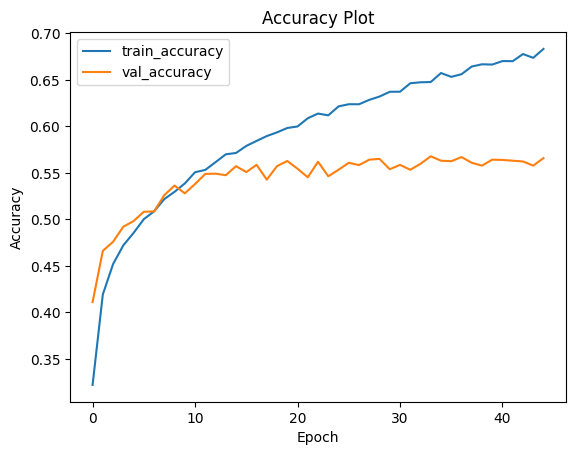

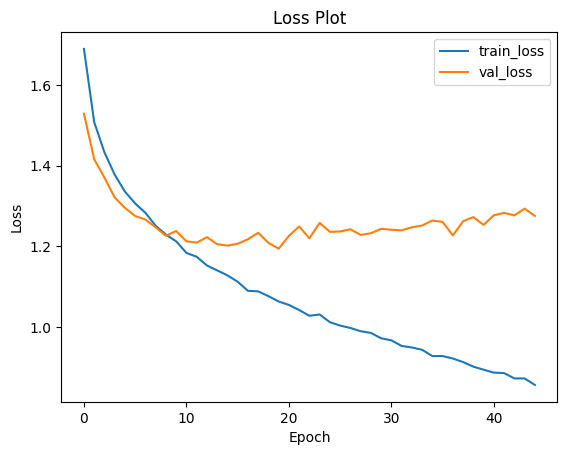

  0%|          | 0/2 [00:00<?, ?it/s]


accuracy,▁▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▅▆▆▇▇▇▇█▇███▇▇█▇▇███▇█▇███████████
val_loss,█▆▅▄▃▃▃▂▂▁▁▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃
accuracy,0.68334
best_epoch,19
best_val_loss,1.19386
epoch,44
loss,0.85579
val_accuracy,0.5659


In [28]:
import scipy
import tensorflow as tf
from wandb.keras  import WandbCallback

class Model:
    img_size = 48
    num_classes = 7
    root_path = "./data/fer"
    batch_size = 64
    epochs = 100
    learning_rate=0.001
    postfix = ""

    def __init__(self):
        self.model = None

    def build_model(self):
        build_model(self)

    def train_model(self, another_callback=[]):
        train_model(self, another_callback)

    def save_model(self):
        save_model(self)

if __name__ == "__main__":
    img_size = 48
    num_classes = 7
    root_path = "./data/fer"
    batch_size = 64
    epochs = 100
    learning_rate=0.001
    postfix = ""
    wandb.init(project="fyp-fer", entity="johnkhw")
    wandb.config = {
        learning_rate,
        epochs,
        batch_size
    }
    wandb_callback = [
        WandbCallback(),
    ]
    model = Model()
    model.build_model()
    model.train_model(wandb_callback)
    model.save_model()
    wandb.finish()

In [33]:

from transformers import pipeline
from transformers import WhisperFeatureExtractor


text = "Buy this Chinese tech giant to play a $284 billion video gaming opportunity: Goldman Sachs"
generator = pipeline(model="jonaskoenig/topic_classification_04")
generator(text)

Some layers from the model checkpoint at jonaskoenig/topic_classification_04 were not used when initializing TFBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at jonaskoenig/topic_classification_04.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


[{'label': 'Business & Finance', 'score': 0.9852411150932312}]